In [5]:
#Step 1
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Importing random forest model and libraries
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score
import scipy as sp
import pickle as pkl
%matplotlib inline

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

In [9]:
import pandas as pd
if True:
    df_P100 = pd.read_csv('p100_all_data.csv', index_col = 0)
    df_V100 = pd.read_csv('v100_all_data.csv', index_col = 0)
    new_df = pd.read_csv('new_df.csv', index_col = 0)
    all_data = pd.read_csv('all_data.csv', index_col = 0)
if True:
    all_data = all_data.dropna(axis=1,how='any')

In [15]:
all_data.shape
new_df.shape

(30622, 120)

In [11]:
#all_data['dram_through']

In [12]:
## new_df = P100 Metrics with V100 IPC
df_new = new_df

#grabbing IPC values
newdf_ipc = df_new.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','application_name','kernelname'])
newdf_ipc = newdf_ipc['ipc']
new_ipc_values = newdf_ipc.values

df_new_norm = df_new.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','application_name','kernelname','ipc'])
df_new_norm = df_new_norm.values
df_new_norm = MinMaxScaler().fit_transform(df_new_norm)

# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split
X_new = df_new_norm
Y_new = new_ipc_values

# Split the data up in train and test sets
X_trainnew, X_testnew, y_trainnew, y_testnew = train_test_split(X_new, Y_new, test_size=0.33, random_state=42)



In [13]:
#Step 2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Creates array of ipc values and array of metrics 
def process(new_df,test_size):
    ipc_values = new_df['ipc'].values
    new_def_norm = new_df.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','ipc','application_name','kernelname'])

    #v100+p100 combined
    new_def_norm_values = new_def_norm.values
    new_def_norm = MinMaxScaler().fit_transform(new_def_norm_values)

    ###!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!####
    X_VP = new_def_norm 
    Y_VP = ipc_values

    # Split the data up in train and test sets
    X_trainVP, X_testVP, y_trainVP, y_testVP = train_test_split(X_VP, Y_VP, test_size=test_size, random_state=42)

    # Import `StandardScaler` from `sklearn.preprocessing`
    from sklearn.preprocessing import StandardScaler

    # Define the scaler 
    #scalerVP = StandardScaler().fit(X_trainVP)
    scalerVP = StandardScaler().fit(X_trainVP)

    # Scale the train set
    X_trainVP = scalerVP.transform(X_trainVP)

    # Scale the test set
    X_testVP = scalerVP.transform(X_testVP)
    
    return X_trainVP, X_testVP, y_trainVP, y_testVP, X_VP, Y_VP



In [164]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Creates array of ipc values and array of metrics 
def process_keep(new_df):
    #new_def_norm = new_df.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','ipc','application_name','kernelname'])
    new_def_norm = new_df.drop(columns=['architecture','input','application_name','kernelname'])

    #v100+p100 combined
    new_def_norm_values = new_def_norm.values
    ##new_def_norm = MinMaxScaler().fit_transform(new_def_norm_values)

    ###!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!####
    ##X_VP = new_def_norm 

    # NOT SPLITTING HERE - Split the data up in train and test sets
    ##X_trainVP, X_testVP, y_trainVP, y_testVP = train_test_split(X_VP, Y_VP, test_size=test_size, random_state=42)

    # Import `StandardScaler` from `sklearn.preprocessing`
    from sklearn.preprocessing import StandardScaler

    # Define the scaler 
    #scalerVP = StandardScaler().fit(X_trainVP)
    ##scalerVP = StandardScaler().fit(X_VP)
    scalerVP = StandardScaler().fit(new_def_norm_values)

    # Scale the train set
    ##X_trainVP = scalerVP.transform(X_VP)
    X_trainVP = scalerVP.transform(new_def_norm_values)

    # Scale the test set
    #X_testVP = scalerVP.transform(X_testVP)
    
    return X_trainVP


In [71]:
#Creating two data sets 
from_scratch = False
df = pd.read_csv('all_data.csv', index_col = 0)
df = df.dropna(axis=1,how='any')
if from_scratch:
    df_check = None
    frames = []
    frame2 = []
    df_v = []
    df_p = []
    for name, item in df.groupby(['kernelname', 'input']):
        df_1 = df[ df['kernelname'] == name[0] ]
        df_2 = df_1[ df_1['input'] == name[1] ]
        if len(df_2) == 2:
            df_v = df_2[df_2['architecture'] == 'V100']
            df_p = df_2[df_2['architecture'] == 'P100']
            #df_p['ipc'][0] = df_v.iloc[0]['ipc']
            frames.append(df_p)
            frame2.append(df_v)

    new_df = pd.concat(frames)
    new_v = pd.concat(frame2)

In [72]:
#print(new_df.shape)
#print(new_v.shape)

In [17]:
## START HERE
from_scratch = False
#####!!!!! start here !!! new data analysis!!!####

In [21]:

if from_scratch:
    new_df.to_csv('cor_p100.csv')
    new_v.to_csv('cor_v100.csv')
else:
    #new_p = pd.read_csv('cor_p100.csv', index_col = 0)
    #new_v = pd.read_csv('cor_v100.csv', index_col = 0)
    #new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/spec_p100.csv', index_col = 0) #using specified kernels
    #new_v = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/spec_v100.csv', index_col = 0) #using specified kernels
    new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_P100_10Per.csv', index_col = 0)
    new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_V100_10Per.csv', index_col = 0)
    
  

In [22]:
#print(new_p.shape)
#print(new_v.shape)
# Need to get correct data shape + set from v100_spec_dataset 

In [23]:
#X_trainP, X_testP, y_trainP, y_testP, X_P, Y_P = process(new_p,.2)
#X_trainV, X_testV, y_trainV, y_testV, X_V, Y_V = process(new_v,.2)

In [165]:
##weighted mse
import keras.backend as K
def weighted_mse(loss_weight):
    def loss(y_true, y_pred):
        #import pdb; pdb.set_trace()
        #y_true = K.variable(y_true)
        #y_pred = K.variable(y_pred)
        #loss = K.mean(K.dot(K.square(y_true - y_pred),loss_weight))
        loss = K.mean(K.square(y_true - y_pred)*loss_weight)
        return loss

    return loss

#in model.compile: loss=weighted_mse(loss_weight) instead of loss='mean_squared_error'

In [166]:
#ipc = 96, dram_read_throughput = 33,dram_write_throughput = 34,  ldst_fu_utilization=105
#cf_fu_utilization = 106, 
#loss_weight = np.ones((116,1)) ##setting model to zero on those two items and see how it changes
loss_weight = np.zeros(116)
loss_weight[96] = 0#17
loss_weight[33] = 100#15 ## increasing dram write and read weights
loss_weight[34] = 100#14
loss_weight[105] = 0#13
loss_weight[106] = 0#10
#print(loss_weight)

In [167]:
#need baselines
"""
1. how does p100 ipc to predict v100 ipc (fit a line)

"""

'\n1. how does p100 ipc to predict v100 ipc (fit a line)\n\n'

In [168]:
#step 3
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers

# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
# load pima indians dataset
#dataset = pd.read_csv("p100_only.csv", delimiter=",").values
# split into input (X) and output (Y) variables
#X = dataset[:,0:8]
#Y = dataset[:,8]
# create model
def my_model(l2_weight):
    model = Sequential()
    """
    #original simple dl model
    model.add(Dense(12, input_dim=112, kernel_initializer='normal',activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='relu'))"""
    #early stopping, smaller layers, less layers
    model.add(Dense(130, input_dim=116, kernel_initializer='normal',activation='relu', kernel_regularizer=regularizers.l2(l2_weight)))
    model.add(Dense(125, activation='relu',kernel_regularizer=regularizers.l2(l2_weight)))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(90, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(110, activation='relu'))
    #rerun and check everything is normalized correctly
    model.add(Dense(125, activation='relu', kernel_regularizer=regularizers.l2(l2_weight)))
    model.add(Dense(116, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_weight)))
    # Compile model
    #mean absolute percentage error - indicating that we seek to minimize the mean percentage difference between 
    #predicted ipc and the actual ipc
    #loss_weight = vector of weights 
    #model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    model.compile(loss=weighted_mse(loss_weight),optimizer='adam',metrics=['mse','mae'])
    # Fit the model
    ## model.fit(X, Y, epochs=10, batch_size=10) ##works
    #look at weighted mean square error - putting more weight on certain metrics 
    """
    # evaluate the model
    scores = model.evaluate(X, Y)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))"""
    return model

In [169]:
###NOTES
"""
Nvidia gives a rough classifier - below and above threshold
- which applications would change class - 'from memory bound to compute bound'
- tool where to focus benchmarking applications
- make sure to get baseline
"""

"\nNvidia gives a rough classifier - below and above threshold\n- which applications would change class - 'from memory bound to compute bound'\n- tool where to focus benchmarking applications\n- make sure to get baseline\n"

In [170]:
"""
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#early stopping - once validation error stops improving, cut it off
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=100, verbose=1, mode='min')
callbacks=earlystop
p_model = my_model()
mc = ModelCheckpoint('filename.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)
#callbacks_list = [earlystop, mc]
p_model.fit(X_trainP, X_trainV, epochs=2000, batch_size=10000, verbose=1,validation_split=0.7,callbacks=[earlystop,mc])

"""

"\nfrom keras.callbacks import EarlyStopping\nfrom keras.callbacks import ModelCheckpoint\n\n#early stopping - once validation error stops improving, cut it off\nearlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=100, verbose=1, mode='min')\ncallbacks=earlystop\np_model = my_model()\nmc = ModelCheckpoint('filename.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)\n#callbacks_list = [earlystop, mc]\np_model.fit(X_trainP, X_trainV, epochs=2000, batch_size=10000, verbose=1,validation_split=0.7,callbacks=[earlystop,mc])\n\n"

In [171]:
#Specified validation sets
XV_val = np.load('XV_val_data_all_metrics.npy')
XP_val = np.load('XP_val_data_all_metrics.npy')

In [156]:
#opening columns
XP_column_names = np.load('column_names.npy')
column_name_dict = {}
for i,name in enumerate(XP_column_names):
    column_name_dict[name] = i

In [157]:
print(XP_column_names.shape)
#print(XP_column_names)
print(column_name_dict['dram_write_throughput'])
print(column_name_dict['dram_read_throughput'])

#XP_val[:,23]
#ipc = 96, dram_read_throughput = 33,dram_write_throughput = 34,  ldst_fu_utilization=105
#cf_fu_utilization = 106, 

(116,)
34
33


In [178]:
# Returns a list of weights for the specified dataset
# indices (`indices`), given the parent dataframe (`df`)
# and a dictionary of weights to apply. Application names
# that are not included in `weights` will be set to 1.0
# does my model put the points in the right region in comparison to the truth values
# you know will be higher for these applications on V100 than P100 - can identify which applications this happens
# !!!!!is there a point where it becomes accurate enough to be useful?   AM_AL_spec_P100_10Per.csv
##new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_P100_20per.csv', index_col = 0) #using specified kernels
new_p = pd.read_csv('/Users/yzamora/power/nvidia_gpus/all_apps/predicted_true_p100.csv')
    
def get_w_vec(df, weights, indices=None):
    w = []
    indices = indices or [i for i in range(len(df))]
    for ind in indices:
        default = 1.0
        name = df.iloc[ind]["application_name"]
        w.append(weights.get(name, default))
    return w

train_weights = get_w_vec(
    new_p,
    {
        "backprop": 1, #-20.0,
        "stream": 1, #10000.0,
        "leuokocyte": 1, #10000.0,
        "hybridsort": 1000, #10000.0,
        "kmeans": 1.0
    },
)  

#len(new_p)
#train_weights

In [179]:
new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_P100_20per.csv', index_col = 0) #
#new_p['kernelname']
#new_p

## Running model with various training data sizes

In [180]:
#step 4
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
all_data = False
p100_p100 = False
p100_v100 = True
def testing_training_size(regularization):
    #training size decreases
    if all_data:
        new_p = pd.read_csv('cor_p100.csv', index_col = 0)
        new_v = pd.read_csv('cor_v100.csv', index_col = 0)
    else: 
        ##new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_P100_20per.csv', index_col = 0) #using specified kernels
        ##new_v = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_V100_20per.csv', index_col = 0)
        new_p = pd.read_csv('/Users/yzamora/power/nvidia_gpus/all_apps/predicted_true_p100.csv') #using specified kernels
        new_v = pd.read_csv('/Users/yzamora/power/nvidia_gpus/all_apps/predicted_true_v100.csv')
        
        #X_trainP, X_testP, y_trainP, y_testP, X_P, Y_P = process(new_p,test_size)
        #X_trainV, X_testV, y_trainV, y_testV, X_V, Y_V = process(new_v,test_size)
        #import pdb; pdb.set_trace()
        #need to preprocess data with splitting it
        X_trainP = process_keep(new_p)
        X_trainV = process_keep(new_v)

        h_model = my_model(regularization)
        #pass in validation data - remove validation split, do not split training set again
        #history = h_model.fit(X_trainP, X_trainV, epochs=100, batch_size=500,  verbose=1, validation_split=0.2)
        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=100, verbose=1, mode='min')
        mc = ModelCheckpoint('membounds_dram_kmeans_zerobias.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)
        #h_model.save('wsame_PV_dl_10per_woutbias' + str(int(regularization)) +'.h5')
        #create a separate vector with a weight for the applications - put this vector into sample weight, after callbacks
        #sample_weight = 
        history = h_model.fit(X_trainP, X_trainV, epochs=1000, batch_size=50,  verbose=1, validation_data=(XP_val,XV_val),callbacks=[earlystop,mc],sample_weight=np.array(train_weights))
        #h_model.save('wAsame_PV_dl_10per_woutbias' + str(int(regularization)) +'.h5')
        return history.history['val_loss']
   
        


In [181]:
#new_p = pd.read_csv('/Users/yzamora/Desktop/ActiveLearningFrameworkTutorial/with_same_base_P100/AM_AL_spec_P100_10per.csv', index_col = 0)
#new_p['dram_utilization']
new_v = pd.read_csv('/Users/yzamora/power/nvidia_gpus/all_apps/predicted_true_v100.csv')
new_v.shape

(2534, 120)

In [182]:
#over sampling certain datapoints 

In [183]:
#step 5
import numpy as np
#Going through 10 different training set sizes and saving results to val_testsize
val_testsize = {}

#for exponent in np.linspace(-8,-3,10,endpoint=True):
#keep for loop to run across all exponents
##for exponent in np.linspace(.5,5,20,endpoint=True):
    #print(test_size)
    ##val_testsize[exponent] = testing_training_size(exponent*10**-6)
    
#testing one size - 4.289473684210526
val_testsize[4.289] = testing_training_size(4.289473684210526*10**-6)
#val_testsize[.2] = testing_training_size(.2)

Train on 2534 samples, validate on 4116 samples
Epoch 1/1000
2534/2534 [==============================] - 4s 2ms/step - loss: 1.8563 - mean_squared_error: 0.9634 - mean_absolute_error: 0.5744 - val_loss: 0.3022 - val_mean_squared_error: 0.2159 - val_mean_absolute_error: 0.4071

Epoch 00001: val_loss improved from inf to 0.30220, saving model to membounds_dram_kmeans_zerobias.h5
Epoch 2/1000
2534/2534 [==============================] - 0s 142us/step - loss: 1.7135 - mean_squared_error: 0.9729 - mean_absolute_error: 0.5736 - val_loss: 0.3020 - val_mean_squared_error: 0.1983 - val_mean_absolute_error: 0.4024

Epoch 00002: val_loss improved from 0.30220 to 0.30198, saving model to membounds_dram_kmeans_zerobias.h5
Epoch 3/1000
2534/2534 [==============================] - 0s 148us/step - loss: 1.6557 - mean_squared_error: 0.9634 - mean_absolute_error: 0.5708 - val_loss: 0.3034 - val_mean_squared_error: 0.1932 - val_mean_absolute_error: 0.4004

Epoch 00003: val_loss did not improve from 0.30

2534/2534 [==============================] - 1s 227us/step - loss: 1.6152 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 0.3035 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00029: val_loss did not improve from 0.30198
Epoch 30/1000
2534/2534 [==============================] - 0s 147us/step - loss: 1.6150 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 0.3036 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00030: val_loss did not improve from 0.30198
Epoch 31/1000
2534/2534 [==============================] - 0s 196us/step - loss: 1.6150 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 0.3033 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00031: val_loss did not improve from 0.30198
Epoch 32/1000
2534/2534 [==============================] - 1s 207us/step - loss: 1.6153 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 


Epoch 00057: val_loss did not improve from 0.30198
Epoch 58/1000
2534/2534 [==============================] - 1s 234us/step - loss: 1.6143 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 0.3034 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00058: val_loss did not improve from 0.30198
Epoch 59/1000
2534/2534 [==============================] - 0s 161us/step - loss: 1.6142 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 0.3031 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00059: val_loss did not improve from 0.30198
Epoch 60/1000
2534/2534 [==============================] - 1s 219us/step - loss: 1.6143 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5702 - val_loss: 0.3033 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00060: val_loss did not improve from 0.30198
Epoch 61/1000
2534/2534 [==============================] - 0s 195us/step - loss: 1.6142 - mea


Epoch 00086: val_loss did not improve from 0.30198
Epoch 87/1000
2534/2534 [==============================] - 0s 151us/step - loss: 1.6127 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5701 - val_loss: 0.3028 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00087: val_loss did not improve from 0.30198
Epoch 88/1000
2534/2534 [==============================] - 0s 164us/step - loss: 1.6129 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5701 - val_loss: 0.3030 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00088: val_loss did not improve from 0.30198
Epoch 89/1000
2534/2534 [==============================] - 0s 120us/step - loss: 1.6128 - mean_squared_error: 0.9515 - mean_absolute_error: 0.5701 - val_loss: 0.3030 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.4041

Epoch 00089: val_loss did not improve from 0.30198
Epoch 90/1000
2534/2534 [==============================] - 0s 141us/step - loss: 1.6125 - mea

## skip if only using one exponent

In [374]:
#print("Runs:", len(val_testsize))
#print("Test size:", val_testsize.keys())
#print(val_testsize[-8.0][-1])
for key,val in val_testsize.items():
    print("Exponent: ", key)
    print("Final Val loss: ", val_testsize[key][-1])
    print("\n")

Exponent:  4.289
Final Val loss:  0.15978504206163427




## Saving results

In [375]:
finalloss_size = {}
finalloss_size[6] = val_testsize[4.289]
df_fl = pd.DataFrame.from_dict(finalloss_size, orient='index')
#df_fl.reset_index().to_csv('ActiveLearn_Loss',index='index')
##df_fl.to_csv('w_both_AL_500_Loss.csv')

## Looking at prediction loss on validation

In [185]:
print(XV_val.shape)
print(XP_val.shape)
gaus_indices = np.load('hybridsort_saved_indices.npy')
print(gaus_indices.shape)

(4116, 116)
(4116, 116)
(51,)


In [186]:
"""
Number of applications in validations:
## Total 4116 ##
backprop 4002
kmeans 4
srad 1 
leukocyte 36
hybridsort 51
gaussian 15
stream 7

"""

'\nNumber of applications in validations:\n## Total 4116 ##\nbackprop 4002\nkmeans 4\nsrad 1 \nleukocyte 36\nhybridsort 51\ngaussian 15\nstream 7\n\n'

In [187]:
from keras.models import load_model
#model_10 = load_model('10perdata_dram_bias.h5',custom_objects={'loss': weighted_mse(loss_weight)})
##model_10 = load_model('20perdata_dram_kmeans_zerobias.h5', custom_objects={'loss':weighted_mse(loss_weight)})
model_10 = load_model('membounds_dram_kmeans_zerobias.h5', custom_objects={'loss':weighted_mse(loss_weight)})
#model_10 = load_model('wsame_PV_dl_10per_woutbias0.h5')
#model_10 = load_model('same_PV_dl_20percmodel116.h5')
#model_10 = load_model('wsame_PV_dl_10per_400.h5',custom_objects={'loss': weighted_mse(loss_weight)})
y_pred = model_10.predict(XP_val)
X_testV = XV_val
#y_pred = y_pred[gaus_indices][:,96] #96 = ipc
#X_testV = X_testV[gaus_indices][:,96] #96 = ipc
y_pred = y_pred[gaus_indices][:,34] #34 = dram_write_throughput
X_testV = X_testV[gaus_indices][:,34] #34 = dram_write_throughput

In [188]:
print(column_name_dict['dram_write_throughput'])


34


In [189]:
y_pred.shape
#y_pred[:,96].shape

(51,)

R: -0.17474171916660441
MAE: 0.0141403093903449
RMSE: 0.026044769368398998


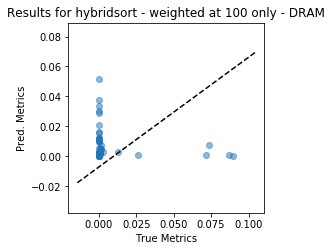

In [190]:


#Averaging down the columns first (metrics), which converts it to 1 error per metric, then averages that (one row)
mse = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))
rmse = np.sqrt(mse)

normX_testV = np.mean(np.mean(np.square(X_testV),axis=0))
#relative to the full scale of all the test data - 3x bigger because it's one number scaling across all metrics
mse_relative = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV
mspe = np.mean(np.mean(np.square(y_pred - X_testV),axis=0))/normX_testV ## ask bethany
rmse_relative = np.sqrt(mspe)

""""""
print ("R:",  sp.stats.pearsonr(X_testV.flatten(), y_pred.flatten())[0])
print ("MAE:", np.mean(np.abs(y_pred.flatten() - X_testV.flatten())))
print ("RMSE:", np.sqrt(np.power(X_testV.flatten()- y_pred.flatten(), 2).mean()))

#left out the mean, i would get the error rate for each metric
#first show val error decreasings as training data increases
#second show that val error can decreases earlier with active learning implementation

#print("MSE:", mse)
#print("RMSE:", rmse)
#print("MSPE:", mspe)

fig, ax = plt.subplots()

# Make the plot
ax.scatter(X_testV, y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True Metrics')
ax.set_ylabel('Pred. Metrics')
#ax.set_ylim([-10,30])
#ax.set_xlim([-10,30])
ax.axis('equal')
fig.set_size_inches(3.5, 3.5)
plt.title('Results for hybridsort - weighted at 100 only - DRAM')
# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');
#plt.savefig('intra_arch_pred.png', bbox_inches='tight')
#not being penalized from predicting value outside of the range

In [ ]:
### dram_Write(x)read(y) for predict and true 

In [230]:
#print(y_pred.shape)
x = np.array([[1,2,3],[1,4,5]])
print(x.shape)
print(x[:,[1]])

(2, 3)
[[2]
 [4]]


## Model Prediction analysis on test data

In [231]:
#step 6 : need to make sure test data imported is correct or 
# if it's validation data set that needs to be imported?
import numpy as np
X_testV = np.load('XV_test_data_all_metrics.npy')
X_testP = np.load('XP_test_data_all_metrics.npy')
y_testV = np.load('y_test_data_all_metrics.npy')
print(X_testV.shape)
print(y_testV.shape)
print(X_testP.shape)
#need to import X_Test from V_100 metrics
#need to compare predictions with true output

(2059, 116)
(2059,)
(2059, 116)


R: 0.5312856394746882
MAE: 0.18932281641601806
RMSE: 0.2909430530667074


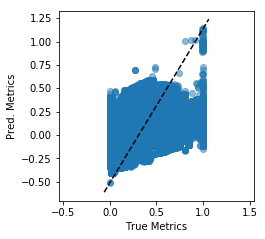

In [232]:
#step 7: analysis of model performance
from keras.models import load_model

#p_model = load_model('PV_dl_20percmodel11620.0.h5')
p_model = load_model('PV_dl_20percmodel1161_92.h5')
y_pred = p_model.predict(X_testP)


#Averaging down the columns first (metrics), which converts it to 1 error per metric, then averages that (one row)
mse = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))
rmse = np.sqrt(mse)

normX_testV = np.mean(np.mean(np.square(X_testV),axis=0))
#relative to the full scale of all the test data - 3x bigger because it's one number scaling across all metrics
mse_relative = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV
mspe = np.mean(np.mean(np.square(y_pred - X_testV),axis=0))/normX_testV ## ask bethany
rmse_relative = np.sqrt(mspe)

""""""
print ("R:",  sp.stats.pearsonr(X_testV.flatten(), y_pred.flatten())[0])
print ("MAE:", np.mean(np.abs(y_pred.flatten() - X_testV.flatten())))
print ("RMSE:", np.sqrt(np.power(X_testV.flatten()- y_pred.flatten(), 2).mean()))

#left out the mean, i would get the error rate for each metric
#first show val error decreasings as training data increases
#second show that val error can decreases earlier with active learning implementation

#print("MSE:", mse)
#print("RMSE:", rmse)
#print("MSPE:", mspe)

fig, ax = plt.subplots()

# Make the plot
ax.scatter(X_testV, y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True Metrics')
ax.set_ylabel('Pred. Metrics')
#ax.set_ylim([-10,30])
#ax.set_xlim([-10,30])
ax.axis('equal')
fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');
#plt.savefig('intra_arch_pred.png', bbox_inches='tight')

## Active learning analysis
Active learning model chooses data set dependent on variance or by random selection. The kernel names are used to pick data points from both P100 and V100 data sets to create new corresponding data sets. These corresponding data points are used to train the deep learning model above to predict all V100 metrics given P100 metrics at different percentages of training data amount. 

In [ ]:
#Used when changing training dataset percentage
#previous method - multiple sizes within DL model
#Getting final val_loss

bar_nam = [.99,.89,.79,.69,.59,.49,.39,.29,.19,.09]
import matplotlib.pyplot as plt
finalloss_size = {}
for k,v in val_testsize.items():
    # get final loss for each test size
    finalloss_size[k] = val_testsize[k][-1]
    #print(k)
#saving data
df_fl = pd.DataFrame.from_dict(finalloss_size, orient='index')
#df_fl.reset_index().to_csv('ActiveLearn_Loss',index='index')
df_fl.to_csv('AL3_Loss.csv')
#print(finalloss_size.keys())
#print(list(finalloss_size.values()))
plt.bar(range(len(finalloss_size)), list(finalloss_size.values()), align='center')
#plt.xticks(range(len(finalloss_size)), list(finalloss_size.keys()))
plt.xticks(range(len(finalloss_size)), bar_nam)
plt.xlabel('Percentage of data used in Training dataset')
plt.ylabel('Final Loss')
plt.title('Loss of data compared to size of training set: Variance Test 2')
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.ylim((0.005,1.25))
plt.savefig("AL3_PV_loss_trainsize_2678.png")
plt.show()

In [ ]:
#Plotting loss vs epoch of different training set sizes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#print(history.history.keys())
# "Loss"
#cycle through entire dataset
"""
for k, v in val_testsize.items():
    #print(k)
    plt.plot(val_testsize[k])
"""
#plot singular run
plt.plot(val_testsize[4.289473684210526])
#plt.plot(val_testsize[0.01])
#plt.plot(val_testsize[0.51])
plt.title('Training data percentage Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['.99', '.89', '.79','.69','.59','.49','.39','.29','.19','.09'], loc='upper right')
plt.savefig("PV_lossepoch_trainsize_2678.png")

plt.show()



## Prediction results of models created above on all data

In [ ]:
from keras.models import load_model
p_model = load_model('dl_model0.11.h5')
new_p = pd.read_csv('cor_p100.csv', index_col = 0)
new_v = pd.read_csv('cor_v100.csv', index_col = 0)
print(new_p.shape)
print(new_v.shape)

In [ ]:
X_trainP, X_testP, y_trainP, y_testP, X_P, Y_P = process(new_p,test_size)
X_trainV, X_testV, y_trainV, y_testV, X_V, Y_V = process(new_v,test_size)
print(X_testP.shape)
print(y_testV.shape)

In [ ]:


y_pred = p_model.predict(X_testP)
#print(y_pred[1])
#print(X_testP[1])
#give it a seed 

#Averaging down the columns first (metrics), which converts it to 1 error per metric, then averages that (one row)
mse = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))
rmse = np.sqrt(mse)

normX_testV = np.mean(np.mean(np.square(y_testV),axis=0))
#relative to the full scale of all the test data - 3x bigger because it's one number scaling across all metrics
mse_relative = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV
mspe = np.mean(np.mean(np.square(y_pred - X_testV),axis=0))/normX_testV ## ask bethany
rmse_relative = np.sqrt(mspe)

#left out the mean, i would get the error rate for each metric
#first show val error decreasings as training data increases
#second show that val error can decreases earlier with active learning implementation

print("MSE:", mse)
print("RMSE:", rmse)
print("MSPE:", mspe)

fig, ax = plt.subplots()

# Make the plot
ax.scatter(X_testV, y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True Metrics')
ax.set_ylabel('Pred. Metrics')
#ax.set_ylim([-10,30])
#ax.set_xlim([-10,30])
ax.axis('equal')
fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');
#plt.savefig('intra_arch_pred.png', bbox_inches='tight')

In [ ]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Plotting predicted vs true
print ("R:",  sp.stats.pearsonr(X_testV.flatten(), y_pred.flatten())[0])
print ("MAE:", np.abs(y_pred.flatten() - X_testV.flatten()) , 's')
print ("RMSE:", np.sqrt(np.power(X_testV.flatten()- y_pred.flatten(), 2).mean()), 's')


fig, ax = plt.subplots()

# Make the plot
ax.scatter(X_testV, y_pred, alpha=0.5)

# Make it pretty
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())

ax.set_xlabel('True Metrics')
ax.set_ylabel('Pred. Metrics')
#ax.set_ylim([-10,30])
#ax.set_xlim([-10,30])
ax.axis('equal')
fig.set_size_inches(3.5, 3.5)

# Add in the goal line
ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--');
plt.savefig("metric_predict.png")

## Showing RMSE for all Metrics

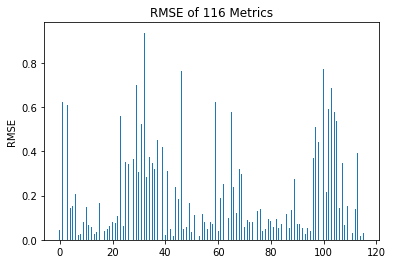

In [36]:
import numpy as np
import matplotlib.pyplot as plt


N = 116
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, np.sqrt(np.mean(np.square(y_pred -X_testV),axis=0)), width)

#Showing which metrics are more difficult to acquire
plt.ylabel('RMSE')
plt.title('RMSE of 116 Metrics')

plt.savefig('RMSE_metrics.png', bbox_inches='tight')
plt.show()


In [60]:
metric_results = np.sqrt(np.mean(np.square(y_pred -X_testV),axis=0))
ind = np.argpartition(metric_results, -10)[-10:]
print(ind)
print('Top most difficult to predict metrics:', XP_column_names[ind])
print("IPC metric number", column_name_dict['ipc'])
print("IPC RMSE value:", metric_results[96])
print('Stall memory dependency RMSE:', metric_results[column_name_dict['stall_memory_dependency']])
print("Memory Bandwidth", column_name_dict['dram_read_throughput'])
print("RMSE Memory Bandwidth", metric_results[33])
print(metric_results[32])
print(XP_column_names[32])

[ 63   1  59 103  29  99  46  32   2 100]
Top most difficult to predict metrics: ['stall_memory_dependency' 'branch_efficiency' 'dram_utilization'
 'l2_utilization' 'local_memory_overhead' 'sm_efficiency' 'gst_efficiency'
 'l2_tex_write_hit_rate' 'warp_execution_efficiency' 'achieved_occupancy']
IPC metric number 96
IPC RMSE value: 0.37079071177670936
Stall memory dependency RMSE: 0.6104020683441777
Memory Bandwidth 33
RMSE Memory Bandwidth 0.28468231052347975
0.9354361222246397
l2_tex_write_hit_rate


In [ ]:
rmse_vals = np.sqrt(np.mean(np.square(y_pred -X_testV),axis=0))

In [ ]:
h_model = my_model()
history = h_model.fit(X_trainP, X_trainV, epochs=200, batch_size=10000,  verbose=1, validation_split=0.2)


In [ ]:
#histogram of different metrics
#RMSE shows that there is around a 1% error in predicting V100 metrics from P100 data

In [ ]:
print(history.history.keys())

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()